# Transfer Learning with MobileNetV2

## 1 - Packages

In [1]:
import numpy as np
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import copy

## 1.1 - Create Dataset
Note: The Alpaca/Non-alpaca dataset doesn't exist in the original github, so we will use the Alien/Predator dataset here https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images and follow the tutorial here https://www.guru99.com/transfer-learning.html. 

In [2]:
directory = "datasets/"
input_size = (224, 224)
BATCH_SIZE = 4
mean = [0.485, 0.456, 0.406]   # These constants are from (https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)
std = [0.229, 0.224, 0.225]   

transform = transforms.Compose([
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(directory, x),
        transform=transform
    )
    for x in ['train', 'validation']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
    for x in ['train', 'validation']
}

In [3]:
# Some info on the dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
print(dataset_sizes)

classes = image_datasets['train'].classes
print(classes)

{'train': 694, 'validation': 200}
['alien', 'predator']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


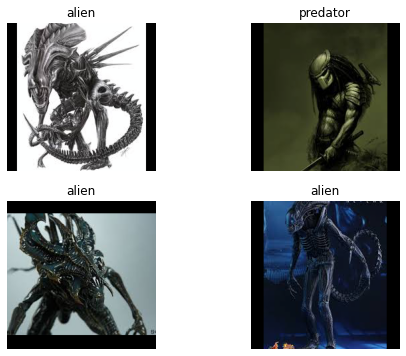

In [4]:
# Visualize some of the images
images, labels = next(iter(dataloaders['train']))

fig = plt.figure(figsize=(8, 6))
for i in range(4):
    fig.add_subplot(2, 2, i+1)
    plt.title(classes[labels[i]])
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 2 - Preprocess and Augment Training Data

## 3 - Using MobileNetV2 for Transfer Learning
We will use the pretrained MobileNetV2 from https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html.

In [5]:
base_model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)
print(base_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 3.2 - Laying Freezing

In [6]:
# Freeze last layer
for param in base_model.parameters():
    param.requires_grad = False

In [7]:
# Modify the last component used for classification
in_features = base_model.classifier[-1].in_features     
features = list(base_model.classifier.children())[:-1]   # Last component without dense layer
features.extend([torch.nn.Linear(in_features, len(classes))])
base_model.classifier = torch.nn.Sequential(*features)   # Override classifier component

**Implementation notes:** 
 * The syntax `*features` unrolls the `features` list so that `torch.nn.Sequential()` receives a variable number of arguments.
 * We could directly tell `in_features = 1280` from `print(base_model)`, but the above syntax is more general.

In [8]:
# Check that our model is updated
print(base_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 3.3 - Fine-tuning the Model

In [9]:
# Our final classification layer can be fine-tuned!
for params in base_model.classifier.parameters():
    print(params.requires_grad)

True
True


In [10]:
def evaluate(model, test_loader):
    was_training = model.training
    model.eval()
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            predictions = model(inputs)
            _, y_pred = torch.max(predictions, 1)
            num_correct += (y_pred == targets).sum().item()
            num_total += targets.shape[0]
    
    model.train(mode=was_training)
    
    return num_correct/num_total
    
    
def train(model, loss_fn, optimizer, train_loader, test_loader, epochs=1, verbose=True): 
    model.train()  
    for epoch in range(epochs):
        running_loss = 0.
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        running_loss /= len(train_loader)
    
        if verbose:
            acc = evaluate(model, test_loader)
            print(f"Epoch: {epoch + 1} | Avg Loss: {loss.item():.4f} | Test accuracy: {acc:.4f}")
        
        scheduler.step()

**PyTorch notes:** The functions `model.train()` and `model.eval()` toggle the modes of the Dropout and BatchNorm layers between training and evaluation mode. See https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch for more details.

In [11]:
# Make a copy of the model to help find good hyperparameters
model = copy.deepcopy(base_model)

In [12]:
NUM_EPOCH = 10
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

In [13]:
train(model, loss_fn, optimizer, dataloaders['train'], dataloaders['validation'], epochs=NUM_EPOCH)

Epoch: 1 | Avg Loss: 0.5263 | Test accuracy: 0.8000
Epoch: 2 | Avg Loss: 0.5635 | Test accuracy: 0.8600
Epoch: 3 | Avg Loss: 0.4325 | Test accuracy: 0.8550
Epoch: 4 | Avg Loss: 0.4995 | Test accuracy: 0.8700
Epoch: 5 | Avg Loss: 0.2637 | Test accuracy: 0.8700
Epoch: 6 | Avg Loss: 0.5173 | Test accuracy: 0.8700
Epoch: 7 | Avg Loss: 0.3395 | Test accuracy: 0.8700
Epoch: 8 | Avg Loss: 0.5102 | Test accuracy: 0.8700
Epoch: 9 | Avg Loss: 0.4612 | Test accuracy: 0.8700
Epoch: 10 | Avg Loss: 0.3562 | Test accuracy: 0.8750


### 3.4 - Visualize the model performance

In [14]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} | truth: {}'.format(classes[preds[j]], classes[labels[j]]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


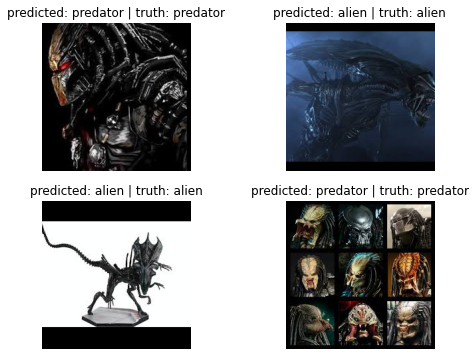

In [16]:
visualize_model(model)
plt.show()